# Evaluation - Business Perspectives and Comparing Models
With the results of both of our trained models, we can now study these in respect to the business setting in which they are located (credit card transactions at retail banks).

In [5]:
# installing dependencies:
!pip install -r ../configs/dependencies/modeling_requirements.txt --upgrade >> ../configs/dependencies/package_installation.txt

In [1]:
# loading magic commands
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
###### Loading the necessary libraries #########

# data wrangling
import pandas as pd
import numpy as np
from tqdm import tqdm

# statistical libraries:
from scipy import stats

# plotting and visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image
import plotly.express as px

# other libraries:
import warnings
import joblib

# sklearn metrics:
from sklearn.metrics import silhouette_score, jaccard_score


# setting global parameters for visualizations:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

<IPython.core.display.Javascript object>

# 0. Helper Functions

In [3]:
def set_plot_settings():
    """Helper function to set standard plot settings for the jupyter notebook
    Note: these are hard-coded for my specific tastes
    """
    %matplotlib inline
    %pylab inline

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.dpi"] = 120
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option("display.expand_frame_repr", False)
    sns.set_style("white")


def rotate_xticks(ax, rotation):
    """Helper function to rotate x-axis labels of a matplotlib-based plot

    Args:
        ax (axes.AxesSubplot): matplotlib subplot axis object that handles the figure
        rotation (int): degrees for which to rotate the axis x-ticks

    Returns:
        None

    """
    for item in ax.get_xticklabels():
        item.set_rotation(rotation)


def plot_clusters(df, cluster_col, palette, plot_title):
    """Helper function to plot results from hdbscan clustering model

    Args:
        x (numpy.array): array for x dimension of the embedding project
        y (numpy.array): array for y dimension of the embedding project
        n_labels (int): number of unique clusters identified

    Returns:
        None (prints to standard out)

    """

    cluster_order = sorted(list(set(df[cluster_col].values)))

    # plotting the results:
    fig, axs = plt.subplots(figsize=(8, 6))

    sns.scatterplot(
        x="emb_x",
        y="emb_y",
        hue=cluster_col,
        hue_order=cluster_order,
        data=df,
        palette=palette,
        alpha=0.6,
        ax=axs,
        legend="auto",
    )

    axs.set(
        title=plot_title,
        xlabel="X-axis projection",
        ylabel="Y-axis projection",
    )

    plt.legend(title="Cluster Labels", loc="best")
    return True


def clean_column_names(col):
    """Simplifies column names from Merchant Category Descriptions"""
    stopwords = ["and", "of", "classified", "not", "elsewhere"]
    col = col.lower()
    col = re.sub(r"[,\)\(']", "", col)
    col = col.replace("—", "")
    col = col.replace(" ", "_")
    col = "_".join([col for col in col.split("_") if col not in stopwords])
    col = col.strip(" ").strip("_")
    return col

<IPython.core.display.Javascript object>

In [4]:
# setting the global variables for plotting:
set_plot_settings()

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

# 1. Loading and Inspecting the Data

In [5]:
# loading the datasets:
PROCESSED_DATA_DIR = "../data/processed/"

<IPython.core.display.Javascript object>

## 1.1 Timeline Dataset

In [6]:
# reading timeline dataset:
df_timeline = pd.read_parquet(PROCESSED_DATA_DIR + "tb_timeline.parquet")

<IPython.core.display.Javascript object>

In [7]:
# checking a sample of the timeline dataset:
df_timeline.sample(5)

,user_id,card_id,transaction_timestamp,transaction_amount,transaction_type,merchant_category_code,merchant_name,merchant_city,merchant_state,zip_code,...,is_first_transaction_of_day,time_between_purchases_in_seconds,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,year,merchant_category_encoding
3487376,29,2,2005-10-08 10:59:00,19.24,Swipe Transaction,4121,7923957867624338208,Whites Creek,TN,37189,...,False,2760.00,7,8,281,40,10,4,2005,🚕
19796827,1590,2,2015-07-21 06:52:00,33.84,Chip Transaction,7538,-6738340320657348028,Bogalusa,LA,70427,...,True,NaN,3,21,202,30,7,3,2015,🚗
2569602,1111,4,2017-01-12 21:34:00,83.31,Chip Transaction,5655,4064673478854767733,Bradenton,FL,34212,...,False,4560.00,5,12,12,2,1,1,2017,👞
232159,864,3,2011-12-01 09:40:00,7.95,Swipe Transaction,8099,7057426219911254853,Rialto,CA,92376,...,True,NaN,5,1,335,48,12,4,2011,🩺
16064281,545,2,2004-04-06 12:04:00,7.69,Swipe Transaction,5499,1799189980464955940,Bradenton,FL,34203,...,False,0.00,3,6,97,15,4,2,2004,🛒


<IPython.core.display.Javascript object>

In [9]:
# sequence dataset:
df_timeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 25 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   user_id                            object        
 1   card_id                            object        
 2   transaction_timestamp              datetime64[ns]
 3   transaction_amount                 float64       
 4   transaction_type                   object        
 5   merchant_category_code             object        
 6   merchant_name                      object        
 7   merchant_city                      object        
 8   merchant_state                     object        
 9   zip_code                           object        
 10  is_fraud                           bool          
 11  merchant_category_description      object        
 12  time_of_day                        object        
 13  transaction_date                   object        
 14  

<IPython.core.display.Javascript object>

## 1.2 Model Results

In [10]:
# loading the model results:
PREDICT_DATA_DIR = "../data/predict/"

# lda results:
df_lda = pd.read_parquet(PREDICT_DATA_DIR + "user_cluster_lda_token_sequence.parquet")

# hdbscan results:
df_hdbscan = pd.read_parquet(PREDICT_DATA_DIR + "user_cluster_doc2vec.parquet")

<IPython.core.display.Javascript object>

In [11]:
# verifying the data integrity:
df_lda.groupby("cluster")[["user_id"]].count()

,user_id
cluster,
0,188
1,106
2,1386
3,149
4,171


<IPython.core.display.Javascript object>

In [12]:
df_hdbscan.groupby("cluster")[["user_id"]].count()

,user_id
cluster,
-1,284
0,337
1,225
2,587
3,352
4,215


<IPython.core.display.Javascript object>

## 1.3 User Embeddings

In [13]:
# loading raw document embeddings
df_raw_embeddings = pd.read_parquet(PROCESSED_DATA_DIR + "tb_user_embeddings.parquet")

<IPython.core.display.Javascript object>

In [14]:
# loading umap projections:
df_umap_projection = pd.read_parquet(
    PROCESSED_DATA_DIR + "tb_user_umap_embeddings.parquet"
)

<IPython.core.display.Javascript object>

In [15]:
# verifying the results:
df_umap_projection.head()

,user_id,emb_x,emb_y
0,1090,9.72,-6.53
1,1159,7.60,-6.34
2,1436,10.22,-8.98
3,1512,4.63,-8.25
4,1572,5.85,-8.24


<IPython.core.display.Javascript object>

In [16]:
df_raw_embeddings.head()

,user_id,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,...,comp_90,comp_91,comp_92,comp_93,comp_94,comp_95,comp_96,comp_97,comp_98,comp_99
0,1090,-11.48,9.16,8.00,-2.37,8.07,-19.63,1.14,-1.15,-4.98,...,-3.97,-7.89,-0.22,-5.49,-5.36,0.33,7.69,-7.06,-11.21,-8.75
1,1159,-6.21,14.42,6.36,-0.03,4.76,6.87,1.72,-2.75,-3.89,...,-4.60,5.49,7.14,-0.79,-0.66,2.22,-2.18,-7.29,-5.07,-6.15
2,1436,-4.55,4.13,7.51,-3.94,2.92,-1.34,-1.84,1.74,9.55,...,8.45,-8.48,5.55,0.08,1.39,1.60,-5.73,14.22,-1.85,-5.02
3,1512,3.30,-6.32,-0.98,0.03,8.87,2.82,3.50,-0.88,-7.63,...,0.81,4.68,-0.08,2.91,5.67,-3.08,10.35,-7.27,-5.03,3.55
4,1572,13.25,-7.47,-1.68,2.26,-0.90,-5.71,5.56,-4.40,-3.01,...,0.96,-1.03,14.38,15.48,-1.23,-3.06,9.34,-9.21,-1.40,-8.16


<IPython.core.display.Javascript object>

# 2. Comparing Models
Unsupervised models can be both analyzed by key metrics, such as the `silhoutte_score`. We can also analyze the results from a business perspective (such as to assess whether model results make sense for a business).

In [17]:
# let's join all representations:
df_emb = df_umap_projection.merge(
    df_lda, how="left", left_on="user_id", right_on="user_id"
)

df_emb = df_emb.merge(df_hdbscan, how="left", left_on="user_id", right_on="user_id")

# chaning column names:
df_emb.columns = ["user_id", "emb_x", "emb_y", "cluster_topic", "cluster_hdbscan"]

<IPython.core.display.Javascript object>

In [18]:
# looking at the results:
df_emb.head()

,user_id,emb_x,emb_y,cluster_topic,cluster_hdbscan
0,1090,9.72,-6.53,1,4
1,1159,7.60,-6.34,1,4
2,1436,10.22,-8.98,2,2
3,1512,4.63,-8.25,0,0
4,1572,5.85,-8.24,0,0


<IPython.core.display.Javascript object>

True

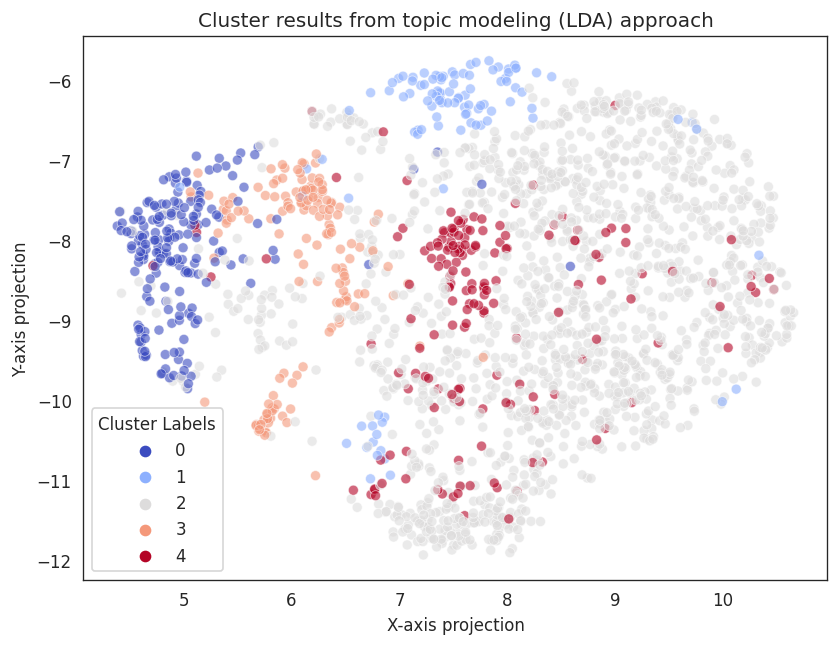

<IPython.core.display.Javascript object>

In [19]:
# plotting the results for each cluster model:
plot_clusters(
    df_emb,
    "cluster_topic",
    "coolwarm",
    "Cluster results from topic modeling (LDA) approach",
)

True

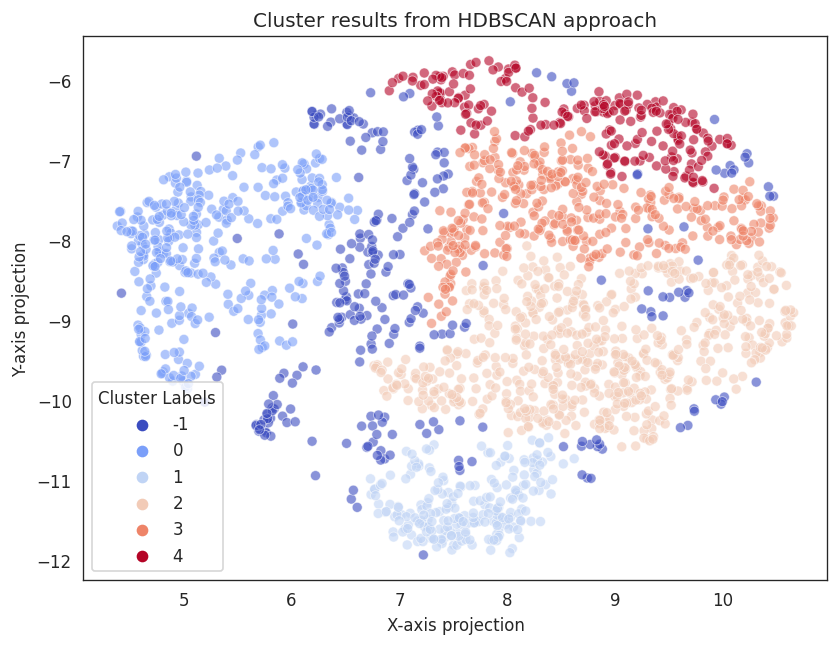

<IPython.core.display.Javascript object>

In [20]:
# plotting the results for each cluster model:
plot_clusters(
    df_emb,
    "cluster_hdbscan",
    "coolwarm",
    "Cluster results from HDBSCAN approach",
)

We can see from the visual inspection above that, we can see some similarities. In fact, the regions of most density in the LDA approach overlap to some extent with that of the HDBSCAN model. The cluster with the highest concentration from the topic model seems to aggregate the users with "regular" behavior (that is, without specific patterns).

## 2.1 Silhoutte Scores
To compare the results from both models, let's calculate silhouette scores with both cases. Since we used cosine similarity when building the models.

### 2.1.1 Topic Clusters

In [21]:
# calculating scores for topics cluster:
silhouette_score(
    df_emb[["emb_x", "emb_y"]].values,
    df_emb["cluster_topic"].values,
    metric="euclidean",
    random_state=42,
)

-0.025529698

<IPython.core.display.Javascript object>

### 2.1.2 HDBSCAN Clusters

In [22]:
silhouette_score(
    df_emb[["emb_x", "emb_y"]].values,
    df_emb["cluster_hdbscan"].values,
    metric="cosine",
    random_state=42,
)

-0.06674617

<IPython.core.display.Javascript object>

Both cases lead to negative silhoutte scores. That makes sense, since we have a large group of users that belong to "unassigned" clusters. Let's filter these out to evaluate the models again.

In [23]:
# filtering out the different models:
df_filter_lda = df_emb[df_emb.cluster_topic != 2].copy()
df_filter_hdbscan = df_emb[df_emb.cluster_hdbscan != -1].copy()

<IPython.core.display.Javascript object>

In [24]:
silhouette_score(
    df_filter_lda[["emb_x", "emb_y"]].values,
    df_filter_lda["cluster_topic"].values,
    metric="euclidean",
    random_state=42,
)

0.2697864

<IPython.core.display.Javascript object>

In [25]:
silhouette_score(
    df_filter_hdbscan[["emb_x", "emb_y"]].values,
    df_filter_hdbscan["cluster_hdbscan"].values,
    metric="cosine",
    random_state=42,
)

0.049679924

<IPython.core.display.Javascript object>

By removing the unassigned users, both cases demonstrated better results, albeit at different levels. While the lda model became much better (from `-0.02` to `0.26`), the difference in the hdbscan case was much less prominent (from `-0.06` to `0.04`). This illustrates that the stricter, more specific topic model representation is more efficient at capturing real differences in the user's sequence of transactions.

Let's now evaluate these clusters from a business standpoint by analyzin key metrics and characteristics of the public.

# 3. Business Metrics Comparison
We will analyze some key business indicators as a means of comparinng the differrent customers produced. Some of these are:

1. Monetary Value, Frequency, Time between purchases (RFM analysis);
2. Spending in different merchant categories;
3. Spending in different types of transactions;
4. Spending in different times of the day;

In [26]:
# adding a support column to the dataset for counting:
df_timeline["support"] = 1
df_timeline.loc[:, "user_id"] = df_timeline["user_id"].astype(int)
df_emb.loc[:, "user_id"] = df_emb["user_id"].astype(int)

<IPython.core.display.Javascript object>

## 3.1 Monetary Value, Frequency of Transactions, Time between purchases

In [27]:
# let's group users by total amount spent:
df_rfm = (
    df_timeline.groupby("user_id")
    .agg(
        {
            "support": np.sum,
            "transaction_amount": [np.sum, np.mean],
            "time_between_purchases_in_seconds": np.nanmean,
        }
    )
    .sort_index()
    .reset_index()
)

<IPython.core.display.Javascript object>

In [28]:
# changing column names:
df_rfm.columns = [
    "user_id",
    "frequency",
    "monetary_value",
    "average_ticket",
    "average_time_between_purchases",
]

<IPython.core.display.Javascript object>

In [29]:
# converting the average_time_between_purchases from seconds to days:
df_rfm.loc[:, "average_time_between_purchases"] = (
    df_rfm["average_time_between_purchases"] / 3600
)

<IPython.core.display.Javascript object>

In [30]:
# joining the results from the clustering:
df_rfm = pd.merge(df_rfm, df_emb, how="left", left_on="user_id", right_on="user_id")

<IPython.core.display.Javascript object>

In [31]:
# verifying the results:
df_rfm.head()

,user_id,frequency,monetary_value,average_ticket,average_time_between_purchases,emb_x,emb_y,cluster_topic,cluster_hdbscan
0,0,19963,1622991.69,81.30,3.27,9.73,-7.61,2,3
1,1,8919,723491.89,81.12,4.12,7.92,-7.23,2,3
2,2,41978,1475933.36,35.16,2.71,4.77,-7.71,0,0
3,3,10117,1186497.51,117.28,3.26,8.93,-10.34,2,2
4,4,18542,1798790.91,97.01,3.33,10.24,-7.46,2,3


<IPython.core.display.Javascript object>

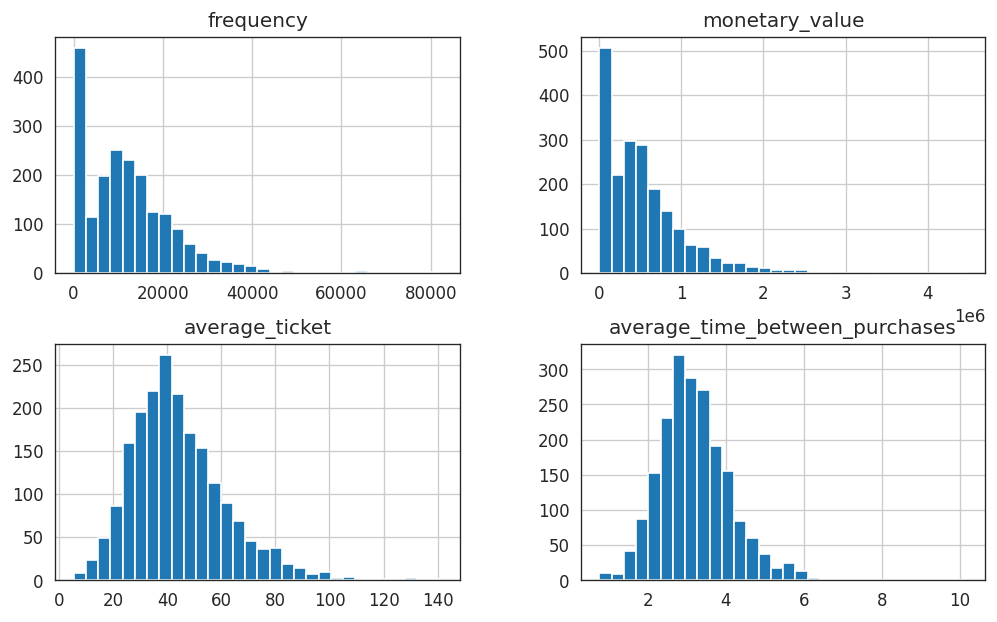

<IPython.core.display.Javascript object>

In [32]:
# visualizing the features:
df_rfm.drop(
    columns=["user_id", "emb_x", "emb_y", "cluster_topic", "cluster_hdbscan"]
).hist(bins=30)

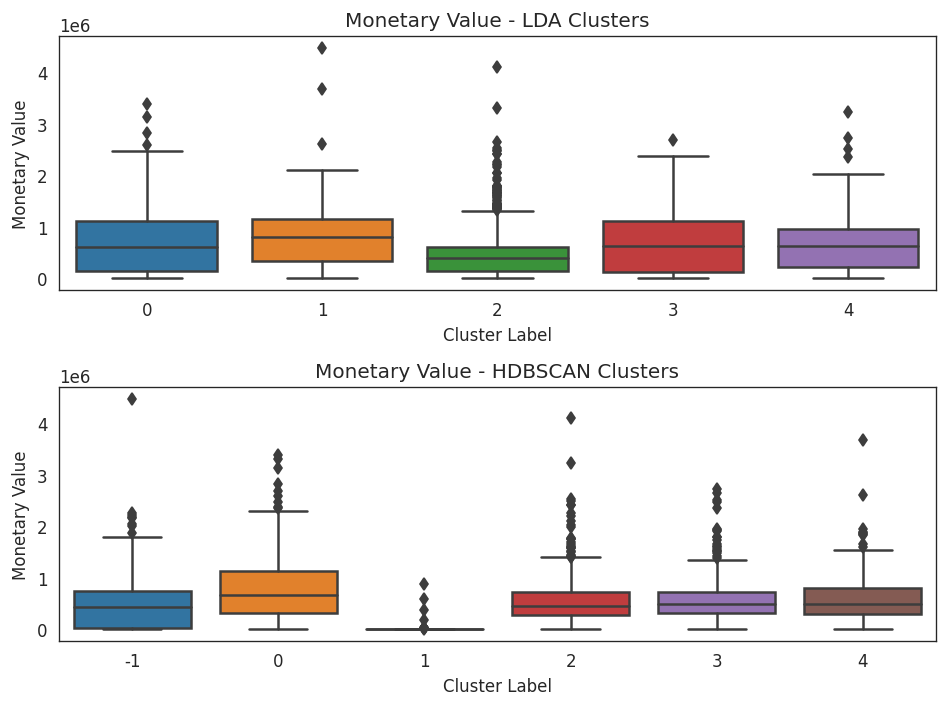

<IPython.core.display.Javascript object>

In [33]:
# let's compare values given their clusters:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sns.boxplot(x="cluster_topic", y="monetary_value", data=df_rfm, ax=axs[0])

sns.boxplot(x="cluster_hdbscan", y="monetary_value", data=df_rfm, ax=axs[1])

axs[0].set(
    title="Monetary Value - LDA Clusters",
    xlabel="Cluster Label",
    ylabel="Monetary Value",
)

axs[1].set(
    title="Monetary Value - HDBSCAN Clusters",
    xlabel="Cluster Label",
    ylabel="Monetary Value",
)

plt.tight_layout()

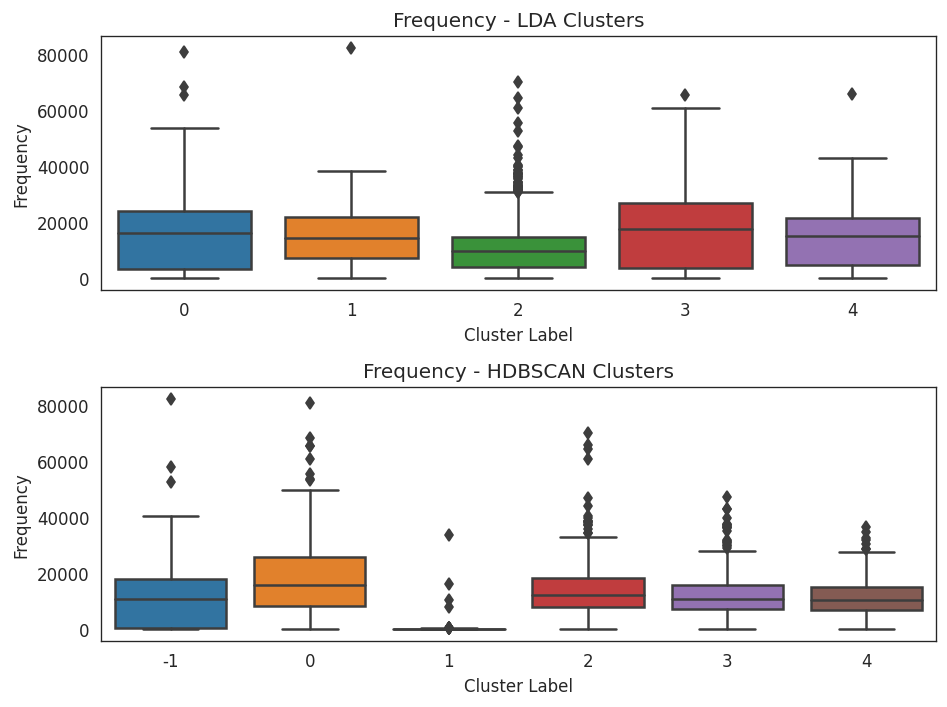

<IPython.core.display.Javascript object>

In [34]:
# let's compare values given their clusters:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sns.boxplot(x="cluster_topic", y="frequency", data=df_rfm, ax=axs[0])

sns.boxplot(x="cluster_hdbscan", y="frequency", data=df_rfm, ax=axs[1])

axs[0].set(
    title="Frequency - LDA Clusters",
    xlabel="Cluster Label",
    ylabel="Frequency",
)

axs[1].set(
    title="Frequency - HDBSCAN Clusters",
    xlabel="Cluster Label",
    ylabel="Frequency",
)

plt.tight_layout()

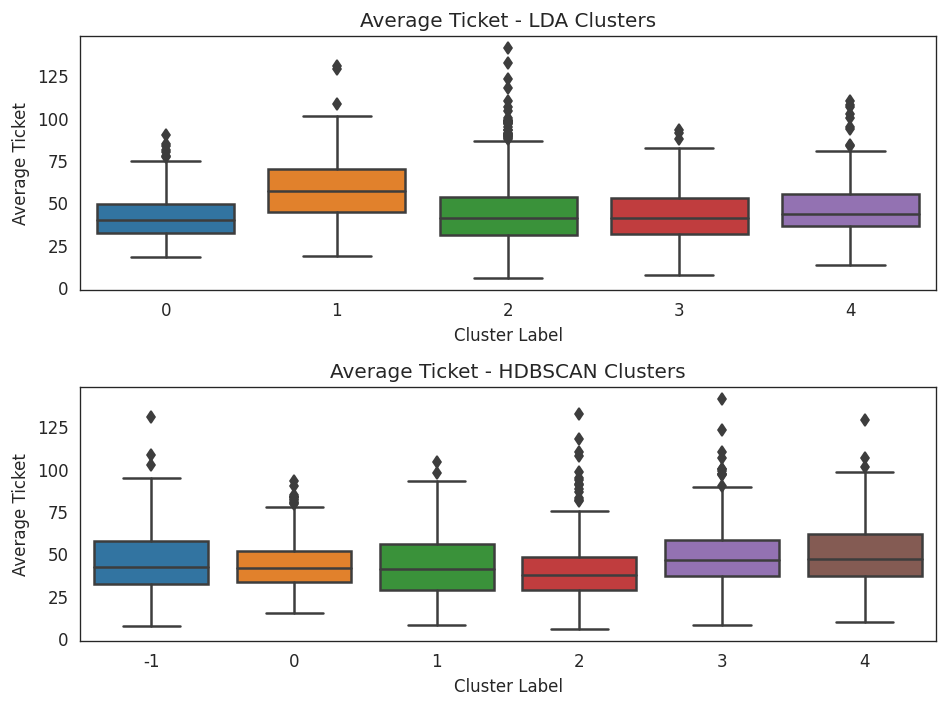

<IPython.core.display.Javascript object>

In [35]:
# let's compare values given their clusters:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sns.boxplot(x="cluster_topic", y="average_ticket", data=df_rfm, ax=axs[0])

sns.boxplot(x="cluster_hdbscan", y="average_ticket", data=df_rfm, ax=axs[1])

axs[0].set(
    title="Average Ticket - LDA Clusters",
    xlabel="Cluster Label",
    ylabel="Average Ticket",
)

axs[1].set(
    title="Average Ticket - HDBSCAN Clusters",
    xlabel="Cluster Label",
    ylabel="Average Ticket",
)

plt.tight_layout()

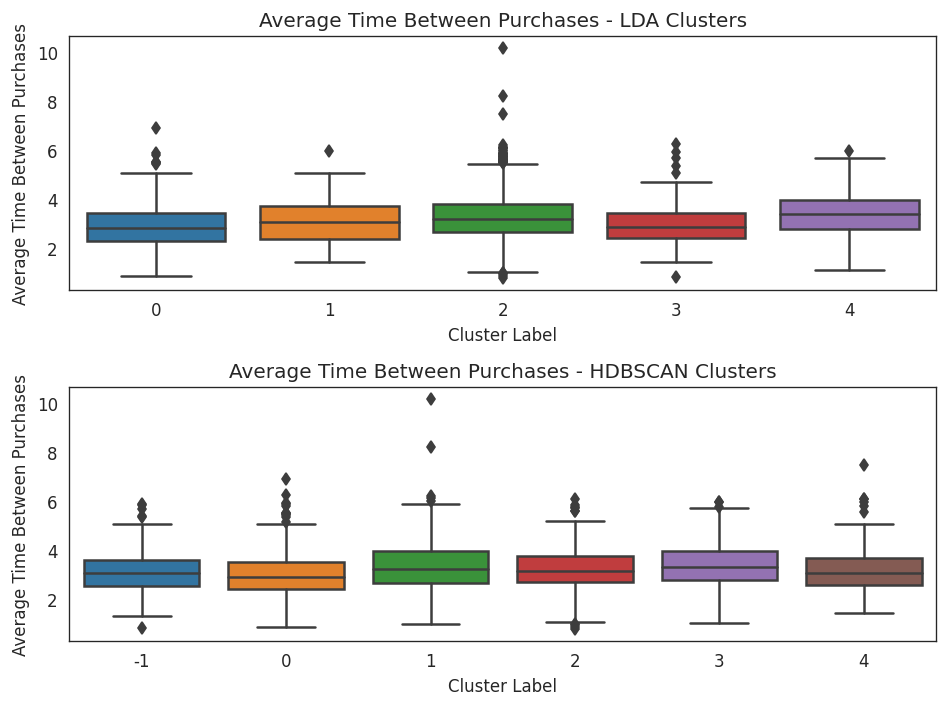

<IPython.core.display.Javascript object>

In [36]:
# let's compare values given their clusters:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

sns.boxplot(
    x="cluster_topic", y="average_time_between_purchases", data=df_rfm, ax=axs[0]
)

sns.boxplot(
    x="cluster_hdbscan", y="average_time_between_purchases", data=df_rfm, ax=axs[1]
)

axs[0].set(
    title="Average Time Between Purchases - LDA Clusters",
    xlabel="Cluster Label",
    ylabel="Average Time Between Purchases",
)

axs[1].set(
    title="Average Time Between Purchases - HDBSCAN Clusters",
    xlabel="Cluster Label",
    ylabel="Average Time Between Purchases",
)

plt.tight_layout()

## 3.2 Spending in Different Categories
Let's now analyze the spending behavior from a `frequency` standpoint.

In [38]:
# let's summarize the spending for all users at the mcc level (pivotting)
df_mccs = (
    df_timeline.groupby(
        ["user_id", "merchant_category_encoding", "merchant_category_description"]
    )
    .agg({"support": np.sum})
    .reset_index()
)

<IPython.core.display.Javascript object>

In [39]:
# verifying the results:
df_mccs.head()  # we need to simplify merchant descriptions

,user_id,merchant_category_encoding,merchant_category_description,support
0,0,⛽,Service stations (with or without ancillary se...,1693
1,0,✈,Airlines and air carriers,70
2,0,✈,Travel agencies and tour operators,84
3,0,🌯,Fast food restaurants,527
4,0,🍺,"Drinking places (alcoholic beverages) — bars, ...",62


<IPython.core.display.Javascript object>

In [40]:
# applying new columnn names
df_mccs.loc[:, "merchant_category_description"] = list(
    map(lambda val: clean_column_names(val), df_mccs.merchant_category_description)
)

<IPython.core.display.Javascript object>

In [41]:
# adding the cluster labels:
df_mccs = pd.merge(
    df_mccs, df_emb, how="left", left_on="user_id", right_on="user_id"
).drop(columns=["emb_x", "emb_y"])

<IPython.core.display.Javascript object>

In [48]:
# groups per cluster type:
df_lda = (
    df_mccs.groupby(
        ["cluster_topic", "merchant_category_encoding", "merchant_category_description"]
    )
    .agg({"support": np.mean})
    .reset_index()
)
df_hier = (
    df_mccs.groupby(
        [
            "cluster_hdbscan",
            "merchant_category_encoding",
            "merchant_category_description",
        ]
    )
    .agg({"support": np.mean})
    .reset_index()
)

<IPython.core.display.Javascript object>

In [49]:
# converting cluster labels to categories:
df_lda.loc[:, "cluster_topic"] = df_lda["cluster_topic"].astype(str)
df_hier.loc[:, "cluster_hdbscan"] = df_hier["cluster_hdbscan"].astype(str)

<IPython.core.display.Javascript object>

In [75]:
# plotting frequency for the LDA clusters
fig = px.bar(
    df_lda,
    x="merchant_category_encoding",
    y="support",
    color="cluster_topic",
    title="Average Frequency Make-up for LDA Clusters per MCC",
    hover_data=["merchant_category_description", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "merchant_category_encoding": "Merchant Category Code",
        "cluster_topic": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

In [72]:
# plotting frequency for the HDBSCAN clusters
fig = px.bar(
    df_hier,
    x="merchant_category_encoding",
    y="support",
    color="cluster_hdbscan",
    title="Average Frequency Make-up for HDBSCAN Clusters per MCC",
    hover_data=["merchant_category_description", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "merchant_category_encoding": "Merchant Category Code",
        "cluster_hdbscan": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

## 3.3 Spending for different types of transactions

In [78]:
# let's verify what types of transactions we have available in the dataset:
df_timeline.groupby("transaction_type")[["support"]].count()

,support
transaction_type,
Chip Transaction,6287598
Online Transaction,2713220
Swipe Transaction,15386082


<IPython.core.display.Javascript object>

In [81]:
# let's group these in terms of how many transactions per cluster belong to which type:
df_types = (
    df_timeline.groupby(["user_id", "transaction_type"])
    .agg({"support": np.sum})
    .reset_index()
)

df_types = pd.merge(
    df_types, df_emb, how="left", left_on="user_id", right_on="user_id"
).drop(columns=["emb_x", "emb_y"])

<IPython.core.display.Javascript object>

In [84]:
# groups per cluster type:
df_lda = (
    df_types.groupby(["cluster_topic", "transaction_type"])
    .agg({"support": np.mean})
    .reset_index()
)
df_hier = (
    df_types.groupby(["cluster_hdbscan", "transaction_type"])
    .agg({"support": np.mean})
    .reset_index()
)

# converting cluster labels to categories:
df_lda.loc[:, "cluster_topic"] = df_lda["cluster_topic"].astype(str)
df_hier.loc[:, "cluster_hdbscan"] = df_hier["cluster_hdbscan"].astype(str)

<IPython.core.display.Javascript object>

In [86]:
# plotting frequency for the LDA clusters
fig = px.bar(
    df_lda,
    x="transaction_type",
    y="support",
    color="cluster_topic",
    title="Average Frequency of Transactionns for LDA Clusters per Transaction Type",
    hover_data=["transaction_type", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "transaction_type": "Transaction Type",
        "cluster_topic": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

In [87]:
# plotting frequency for the HDBSCAN clusters
fig = px.bar(
    df_hier,
    x="transaction_type",
    y="support",
    color="cluster_hdbscan",
    title="Average Frequency of Transactionns for HDBSCAN Clusters per Transaction Type",
    hover_data=["transaction_type", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "transaction_type": "Transaction Type",
        "cluster_hdbscan": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

## 3.4 Spending in different times of the day

In [90]:
# let's verify what the different times of day categories we have available in the dataset:
df_timeline.groupby("time_of_day")[["support"]].count()

,support
time_of_day,
Afternoon,7363487
Early Morning,1371602
Morning,11347827
Night,4303984


<IPython.core.display.Javascript object>

In [91]:
# let's group these in terms of how many transactions per cluster belong to which time of day:
df_time = (
    df_timeline.groupby(["user_id", "time_of_day"])
    .agg({"support": np.sum})
    .reset_index()
)

df_time = pd.merge(
    df_time, df_emb, how="left", left_on="user_id", right_on="user_id"
).drop(columns=["emb_x", "emb_y"])

<IPython.core.display.Javascript object>

In [93]:
# groups per cluster type:
df_lda = (
    df_time.groupby(["cluster_topic", "time_of_day"])
    .agg({"support": np.mean})
    .reset_index()
)

df_hier = (
    df_time.groupby(["cluster_hdbscan", "time_of_day"])
    .agg({"support": np.mean})
    .reset_index()
)

# converting cluster labels to categories:
df_lda.loc[:, "cluster_topic"] = df_lda["cluster_topic"].astype(str)
df_hier.loc[:, "cluster_hdbscan"] = df_hier["cluster_hdbscan"].astype(str)

<IPython.core.display.Javascript object>

In [94]:
# plotting frequency for the LDA clusters
fig = px.bar(
    df_lda,
    x="time_of_day",
    y="support",
    color="cluster_topic",
    title="Average Frequency of Transactionns for LDA Clusters per Time of Day",
    hover_data=["time_of_day", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "time_of_day": "Time of Day",
        "cluster_topic": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

In [96]:
# plotting frequency for the HDBSCAN clusters
fig = px.bar(
    df_hier,
    x="time_of_day",
    y="support",
    color="cluster_hdbscan",
    title="Average Frequency of Transactionns for HDBSCAN Clusters per Time of Day",
    hover_data=["time_of_day", "support"],
    labels={
        "support": "Average Frequency of Purchases",
        "time_of_day": "Time of Day",
        "cluster_hdbscan": "Cluster Label",
    },
    color_discrete_sequence=px.colors.qualitative.T10_r,
    template="ggplot2",
)

fig.update_xaxes(categoryorder="category ascending", showgrid=False, ticks="outside")

fig.update_layout(
    title_font_size=20,
)

fig.show()

<IPython.core.display.Javascript object>

## 4. Characterizing the Clusters
After analyzing the different clusters produced, I derived th following descriptions for the clusters produced. I will describe them based on the model that produced the clusters.

## 4.1 LDA Clusters

### 4.1.1 Cluster 0: The Car Owners
These users differ from the other groups as they have regular expenses associated with **owning a car** (`toll fees`, `gas stations`), while spending less in categories that point out to **not owning a car** (`car rentals`, `taxi`, `uber and other ride-sharing services`). Interestingly, they seem comfortable with making online purchases.

### 4.1.2 Cluster 1: The Providers
These users are mainly distinguished by the recurrence of costs associated with `money orders and transfers` and quite regular spending behaviors in the other categories. This behavior seems to suggest that they are both spending regularly in order situations but also use `money order and transfer` services more often than the average user. These might be financially maintaining other people (perhaps a son or daughter) abroad or in another context that requires such services.

### 4.1.3 Cluster 2: The Average "User"
This group of users represents the regular user base. They don't display any specific distinguishing behavior and are characterizing by using their credit card on a variety of situations. In real world scenarios, this kind of cluster often shows up, and it is a regular pattern. The researchers in the [paper used as motivation for this project]() also concluded on the existing of this group of users.

### 4.1.4 Cluster 3: The Uber Rider
This group is mainly characterized by recurrent expenses with **private transportation** (namely `private ride-sharing` and `taxis`), given their spending on different categories and preferred methods of payment (`online` transactions are more significant in this group). They regularly use these alternatives to commute to work in the `mornings` (more frequent use of credit cards in the morning) and to generally get around town (`afternoon` expenses are also significant).

### 4.1.5 Cluster 4: The Dine-outs
This cluster is distinguished by the recurrent expenses in **dine-out experiences** (`restaurants`, `fast food places`). They are likely younger people who are living alone, as they still likely don't own a car (regular expenses on `commuting` and `public transportation`).

## 4.2 HBDSCAN Clusters

### 4.2.1 Cluster 0: The Heavy Users
This group is mainly characterized by generally more frequent expenses in most popular categories, with a significant distinction in `private transportation`. These are users are likely younger people with higher-than-average income who have diverse expenses but also spend more on items that users working on budget would not spend (such as private transportation). 

### 4.2.2 Cluster 1: The Light Users
This cluster holds users that have engaged very little with the credit card. They might not be very active users of this specific bank (using it only sporadically) or might not have spare income for more credit card use. They don't have any distinguishing spending characteristic, spending on everything but at lower frequencies.

### 4.2.3 Cluster 2 and 3: The Foodies
This cluster is mainly characterized by regular expenses related to food (`supermarket`, `fast food`, `restaurants`, et cetera), being, on average, significantly more frequent users in these kinds of merchants. I opted out for grouping clusters `2` and `3` due to their similarity and lack of distinguishing features between themselves.

### 4.2.4 Cluster 4: The Providers
This cluster displays very similar spending behavior to that of the cluster with the same from the `lda` results. This makes sense, since they are located in the same region of the UMAP projection we generated before. We will maintain the same name and key characteristics.

# 5. Interpretation of the results
To wrap up this project and experiment, I will write my considerations about what kinds of patterns of spending behavior we've seen to obtain with our clustering models. For that, I will also consider the practical aspects of both approaches and which one I would choose for a productive use-case.

## 5.1 Regarding raw spending
While analyzing the distributions per cluster label for both clustering strategies we generally **don't observe significant differences in terms of raw spending patterns**, which is something that **purposely set out to do**. Apart from Cluster's `0` and `1` from the HDBSCAN results (which are better described by frequent and infrequent credit card users), this intention over the project holds quite well.

Common approaches in clustering user spending behavior is to use their spending make-up. By using monetary value as the main feature, we might obtain unintended artifacts that deviate from the objective of uncovering lifestyles or relevant buying patterns. Normally, this would lead to finding clusters of users that spend a lot and users that spend less. 

If we're interested in identifying heavy spenders from regular users, that might be a good approach, otherwise, it generates noise in our results.

We can see from the results from the `hdbscan` cluster that, even though we didn't explicitly tried to uncover heavy spending patterns with our features, we ended picking up a cluster that spends a lot less than normal (*light spenders* - `cluster 1`). This is likely due to problems related to size of documents (users that don't have large sequences or history similar to the other). 

This is a problem that might also affect the `lda` clusters as the user base grows, since short documents can lead to sparser representations in the `bag-of-words` model.

## 5.2 Regarding spending in different merchant categories
There are about `55` different merchant categories in which the customers spent something. Although in the real world there might be a lot mor e (the [Mastercard Merchant Guide](https://www.mastercard.us/content/dam/mccom/en-us/documents/rules/quick-reference-booklet-merchant-edition.pdf) lists about 1300 MCCs), requiring us to use merchant group instead of raw codes, we will keep these `55` groups as they are for this project, due to the relatively low cardinality presented. 

The spending make-up in the different categories (here represented as `emoji` characters) is the core of our approach, as they are inherently tied to the sequences of transactions for each customer. 

By analyzing these different patterns, we were able to create interesting `groups` that have distinguishing features (or might be characterized by the lack of any such feature). 

While in some cases the clusters described intersected (as is the case of the `Providers`), in the `HDBSCAN` approach, we were more affected by `spending` biases. That is, this approach led to some clusters that identified groups that spend more often and others that spend less often, which was not the ultimate goal of the project. We could also note that the number of clusters generated might not have been the best, as two clusters were very similiar (`Foodies`). 

This can be remediated with better selection of hyperparameters for a newer interation of this project. We can also limit the size of documents (`user-sequences`), such as to not favor very long (and thus very active) users. These improvements might also improve the `silhoutte_score` for `HDBSCAN` case to a more. comparable level of that of the `lda` approach.

## 5.3 Regarding time of day and transaction types
Both of these analyses were geared towards understanding sociodemographic make-ups a little better in the absence of them (as is the case of this dataset). Results from the clusters were not much different and clusters generally display very similar behaviors. In some cases, we observed higher tendencies for purchasing online than usual or spending more at a particular time of day (such as in the morning). However, without more demographic observations, it is not very accurate to suggest real differences. 

Incorporating demographic data to this project might lead to better results and it is a logical next step in its development.

# 6. Conclusion
By leveraging sequences of credit card purchases in different merchant categories from a small but active user base, we were able to uncover significant spending behaviors that represent the "lifestyles" of the customers. We utilized techniques that are often applied to `text mining` in this context successfully using the assumption that the similar distribution of the data to that of text corpora yields similar results when such techniques are applied. 

In fact, the `topic modeling`, which in our case is analogous to clustering, yielded distinct groups that are very useful for targeted campaings and specific communications. Not only the topic modeling approach had demonstrably better clustering results (high coherence, better silhoutte score) but also had better business potential for the use case of inferring customer lifestyles.

Although the `topic` model is a bit harder to comprehend and illustrate, it is easier to put into production, since the entire modeling and innference pipelines can be implemented in distributed means, such as in `Apache Spark`. For larger user bases, the time it would take to train and make predictions with such model would be prohibitively long, but with distributed capabilities, these `batch` operations can be tamed quite well.